In [1]:
#### library package
pacman::p_load(Seurat, dplyr, ggplot2, stringr, magrittr, reticulate, reshape2, tidyverse, ggsci, knitr, harmony, cowplot, RColorBrewer, 
               tidyr, patchwork, ggrepel, homologene, scico, DropletUtils, scCustomize, tidydr, Matrix, DoubletFinder, data.table, ggpubr, 
               ggthemes, extrafont, sysfonts, viridis, openxlsx, paletteer)

[1] "preparation done"


# load data

In [ ]:
meta_path <- data.frame(meta_path = list.files('/project/sex_cancer/data/AML_Galen2019') %>% .[grepl('anno.txt', .)]) %>%
             mutate(sampleID = strsplit2(meta_path, split = '_')[,2] %>% gsub('.anno.txt', '', .)) %>% .[order(.$sampleID),]
exp_path <- data.frame(exp_path = list.files('project/sex_cancer/data/AML_Galen2019') %>% .[grepl('dem.txt', .)]) %>%
            mutate(sampleID = strsplit2(exp_path, split = '_')[,2] %>% gsub('.dem.txt', '', .)) %>% .[order(.$sampleID),]
file_path <- merge(meta_path, exp_path, by = 'sampleID')

In [ ]:
obj_list <- lapply(1:nrow(file_path), function(x){
                    meta <- fread(paste('/project/sex_cancer/data/AML_Galen2019/', file_path[x, 2], sep = '')) %>% transform(barcode = Cell) %>% column_to_rownames('Cell')
                    exp <- fread(paste('/project/sex_cancer/data/AML_Galen2019/', file_path[x, 3], sep = '')) %>% column_to_rownames('Gene') %>% .[, rownames(meta)] %>% as.sparse() 
                    CreateSeuratObject(counts = exp, assay = 'RNA', meta.data = meta, min.cells = 0, min.features = 0, project = 'AML_Galen2019')
                })

## data merge
obj.AML <- merge(obj_list[[1]], obj_list[-1])
obj.AML

# filter sample

In [3]:
obj.AML <- obj.AML %>% 
           subset(Tissue == 'Bone marrow') %>%  ## remove cellline sample
           subset(time == 'D0' | sample %in% c('BM1', 'BM2', 'BM3', 'BM4')) %>% ## remove treated samples
           subset(sample != 'BM5') ## remove sorted samples
table(obj.AML$sample, obj.AML@meta.data$Sex)
unique(obj.AML$CellType)

# modify meta.data

In [4]:
table(colnames(obj.AML) == rownames(obj.AML@meta.data))
table(obj.AML$`Days from diagnosis`)

In [1]:
obj.AML@meta.data <-obj.AML@meta.data %>%
                    dplyr::select(-(names(obj.AML@meta.data) %>% .[grepl('Score', .)])) %>%
                    dplyr::rename(c('DonorID' = 'sample', 'SampleID' = 'orig.ident')) %>%
                    transform(Sex = ifelse(Sex == 'Female', 'F', 'M')) %>%
                    transform(SampleType = ifelse(grepl('AML', .$DonorID), 'tumor', 'normal')) %>%
                    transform(Cohort = 'AML_Galen2019') %>%
                    transform(Chemistry = 'Seq-Well')

# CT annotation

## assign dCT/mCT

In [146]:
obj.AML@meta.data <-obj.AML@meta.data %>% 
                    transform(dCT = CellType) %>% 
                    mutate(mCT = case_when(CellType %in% c('B', 'Plasma', 'ProB', 'NK', 'CTL', 'T') ~ 'Lymphoid',
                                           CellType %in% c('earlyEry', 'lateEry') ~ 'Erythroid',
                                           CellType %in% c('cDC', 'cDC-like', 'pDC', 'GMP', 'GMP-like', 'Mono', 'Mono-like', 'ProMono', 'ProMono-like') ~ 'Myeloid',
                                           CellType %in% c('HSC', 'HSC-like', 'Prog', 'Prog-like') ~ 'Undiff',
                                           TRUE ~ 'Others'))
table(obj.AML$CellType, obj.AML$mCT)
table(obj.AML$mCT, obj.AML$PredictionRefined)

              
               Erythroid Lymphoid Myeloid Undiff
  B                    0      404       0      0
  cDC                  0        0     501      0
  cDC-like             0        0    1945      0
  CTL                  0      436       0      0
  earlyEry           723        0       0      0
  GMP                  0        0     662      0
  GMP-like             0        0    1741      0
  HSC                  0        0       0    306
  HSC-like             0        0       0   1440
  lateEry            437        0       0      0
  Mono                 0        0    1166      0
  Mono-like            0        0    2403      0
  NK                   0      479       0      0
  pDC                  0        0     127      0
  Plasma               0      284       0      0
  ProB                 0      179       0      0
  Prog                 0        0       0    806
  Prog-like            0        0       0   2723
  ProMono              0        0     804      0
  Pro

           
            malignant normal unclear
  Erythroid         0   1160       0
  Lymphoid          0   3189       0
  Myeloid        7478   2632     628
  Undiff         4163    833     279

## assign gCT

In [150]:
obj.AML@meta.data <-obj.AML@meta.data %>% 
                    mutate(gCT = case_when(mCT %in% c('Myeloid', 'Undiff') ~ 'Tumor',
                                           mCT %in% c('Lymphoid', 'Erythroid') ~ 'Immune',
                                           TRUE ~ 'Others'))
table(obj.AML$dCT, obj.AML$gCT)
table(obj.AML$gCT, obj.AML$PredictionRefined)

              
               Immune Tumor
  B               404     0
  cDC               0   501
  cDC-like          0  1945
  CTL             436     0
  earlyEry        723     0
  GMP               0   662
  GMP-like          0  1741
  HSC               0   306
  HSC-like          0  1440
  lateEry         437     0
  Mono              0  1166
  Mono-like         0  2403
  NK              479     0
  pDC               0   127
  Plasma          284     0
  ProB            179     0
  Prog              0   806
  Prog-like         0  2723
  ProMono           0   804
  ProMono-like      0  1389
  T              1407     0

        
         malignant normal unclear
  Immune         0   4349       0
  Tumor      11641   3465     907

# run UMAP

$PCselect
[1] 13 43 13

$p


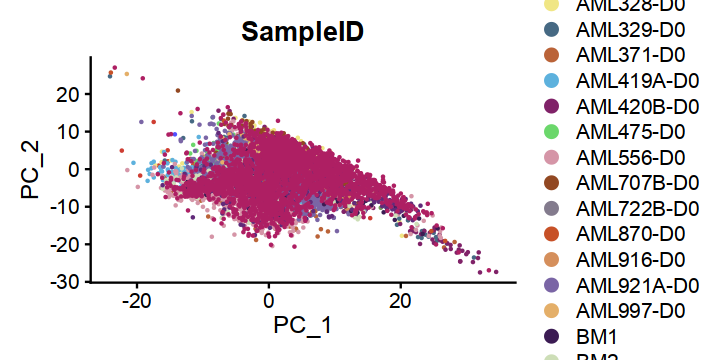

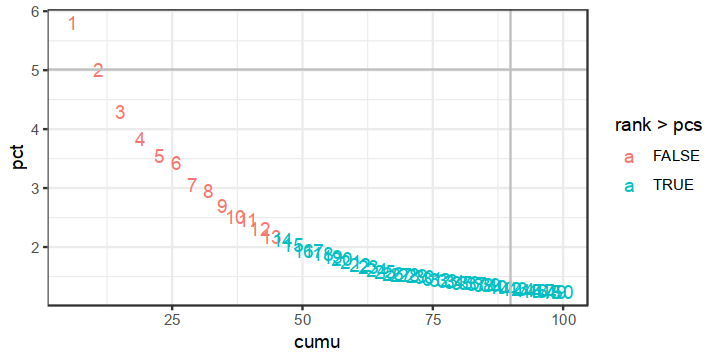

In [161]:
obj.AML <- obj.AML %>%
           NormalizeData(normalization.method = "LogNormalize", scale.factor = 10000, verbose = F) %>%
           FindVariableFeatures(selection.method = "vst", nfeatures = 3000, verbose = F) %>%
           ScaleData(vars.to.regress = c("nCount_RNA"), verbose = F) %>%
           RunPCA(verbose = F)

options(repr.plot.height = 3, repr.plot.width = 6)
DimPlot(object = obj.AML, reduction = "pca", group.by = "SampleID", cols = paletteer_d("ggsci::default_igv"))
PC_selection(obj.AML)

In [5]:
obj.AML <- obj.AML %>% RunHarmony(group.by.vars = "SampleID", plot_convergence = TRUE)
## cluster
nPC <- min(PC_selection_harmony(obj.AML)$PCselect)
nPC

obj.AML <- obj.AML %>% 
           RunUMAP(reduction = "harmony", dims = 1:nPC, umap.method = "uwot") %>%
           RunTSNE(reduction = "harmony", dims = 1:nPC)

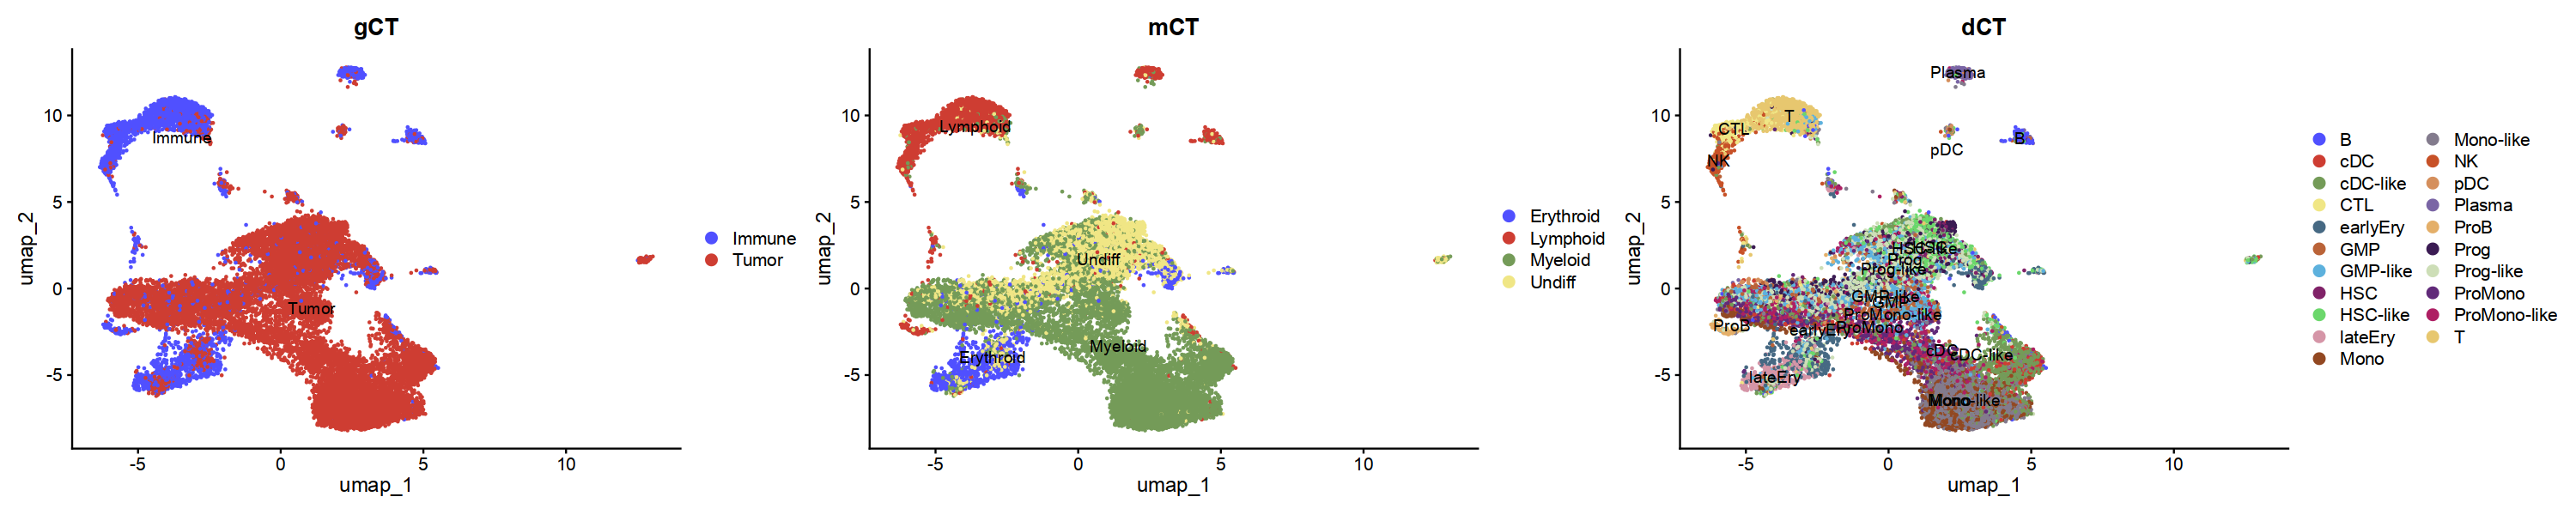

In [172]:
options(repr.plot.height = 5, repr.plot.width = 25)
select <- 'umap'
DimPlot_scCustom(obj.AML, pt.size = .1, group.by = "gCT", reduction = select, label = TRUE, label.size = 4, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.AML, pt.size = .1, group.by = "mCT", reduction = select, label = TRUE, label.size = 4, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.AML, pt.size = .1, group.by = "dCT", reduction = select, label = TRUE, label.size = 4, colors_use = pal_igv("default")(51))
# DimPlot_scCustom(obj.AML, pt.size = 1, group.by = "oCT", label = TRUE, label.size = 4, colors_use = paletteer::paletteer_d('palettesForR::Web', 100))

In [9]:
obj.AML@meta.data[,c('SampleID', 'SampleType', 'Sex')] %>% .[!duplicated(.$SampleID),] %$% table(.$SampleType, .$Sex)
obj.AML@meta.data %$% table(.$SampleType)

        
          F  M
  normal  0  4
  tumor   6 10


normal  tumor 
  4677  15685 

# save

In [19]:
saveRDS(obj.AML, 'obj.AML.use.rds')